## Correlations and Copulas Exercises
This notebook implements the more difficult exercises involving Gaussian copulas. I make heavy use of the [SciPy](https://docs.scipy.org/doc/scipy/reference/index.html) and [TensorFlow 2](https://www.tensorflow.org/api_docs/python/tf) libraries in these exercises.

In [1]:
import numpy as np
import pandas as pd
import locale
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from scipy.stats import multivariate_t
from scipy.stats import norm
from scipy.stats import triang
from scipy.stats import expon
from scipy.stats import t
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from math import sqrt, exp, log
from functools import partial

In [2]:
locale.setlocale(locale.LC_ALL, '')

'en_US.UTF-8'

#### Exercise 11.8
Answers from the textbook

 _ | 0.25 | 0.5 | 0.75
--- | --- | --- | ---
**0.25**|0.095|0.163|0.216
**0.5**|0.163|0.298|0.413
**0.75**|0.216|0.413|0.595

In [3]:
# V1 is uniform [0, 1], V2 is uniform [0, 1]
# Gaussian copula correlation between V1 and V2 is 0.3
u1u2_bivar = multivariate_normal(cov=[[1, .3],[.3, 1]])
quantiles = [.25, .5, .75]

In [4]:
# Maps 'x' percentile to percentile from the uniform [0, 1] to the standard normal distribution
from_uniform_to_normal = lambda x: norm.ppf(uniform.cdf(x))

In [5]:
# Let's map uniformly distributed values to those distributed using the standard normal distribution
mapped_quantiles = list(map(from_uniform_to_normal, quantiles))

In [6]:
# Constucting a cumulative distribution table as a numpy matrix
l = len(quantiles)
cum_matrix = np.empty((l, l), dtype=np.float64)
for i in range(l):
    for j in range(l):
        cum_matrix[i, j] = u1u2_bivar.cdf([mapped_quantiles[i], mapped_quantiles[j]])

In [7]:
# Converting to a dataframe for ease of display
cum_matrix_df = pd.DataFrame(cum_matrix, index=quantiles, columns=quantiles)
cum_matrix_df

,0.25,0.50,0.75
0.25,0.095103,0.163347,0.215757
0.50,0.163347,0.298493,0.413347
0.75,0.215757,0.413347,0.595103


#### Exercise 11.12
Answer from the textbook:
* Probability of V2 < 0.1 conditional on V1 < 0.1: 0.12
* Probability of V2 < 0.2 conditional on V1 < 0.1: 0.34

Probability of V2 < 0.1 conditional on V1 = 0.1: 0.07754095638431419
Probability of V2 < 0.1 conditional on V1 < 0.1: 0.12425188645849872
Probability of V2 < 0.2 conditional on V1 = 0.1: 0.25054356715670495
Probability of V2 < 0.2 conditional on V1 < 0.1: 0.3357848712044022


Text(0.5, 0, 'V2')

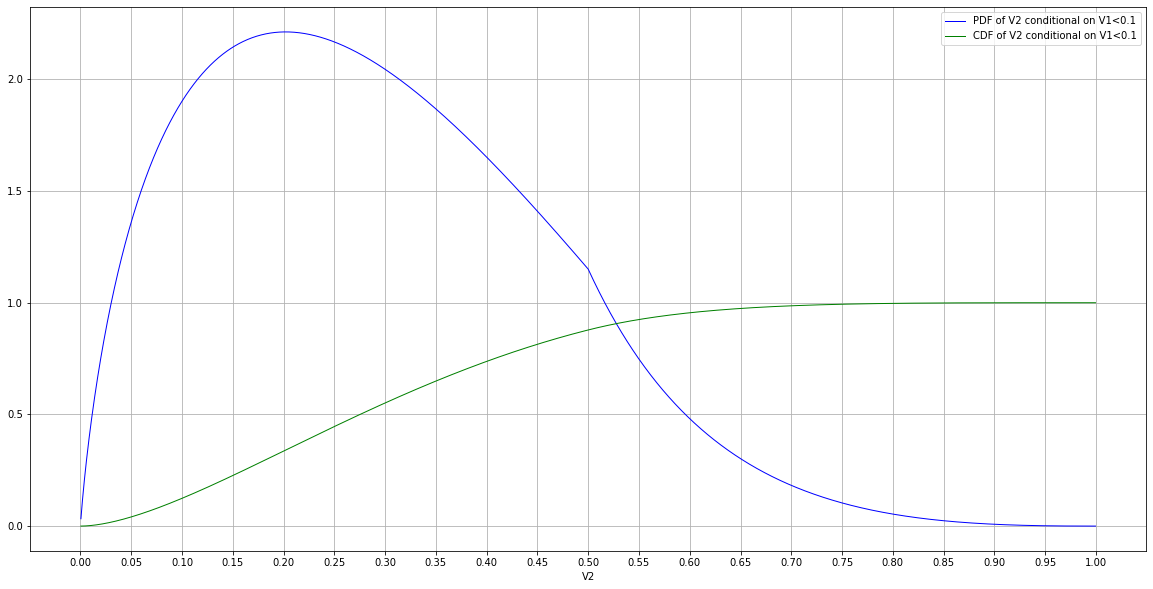

In [8]:
# First let's reconstruct the distributions of V1 and V2
triang1_obj = triang(c=.2)
triang2_obj = triang(c=.5)

# Copula correlation between V1 and V2
ρ = .5

# Bivariate normal distribution with a correlation of 0.5 and a variance of 1
u1u2_bivar = multivariate_normal(cov=[[1, ρ],[ρ, 1]])

# Maps 'x' percentile to percentile from a triangular to the standard normal distribution
from_v1_to_u1 = lambda x: norm.ppf(triang1_obj.cdf(x))
from_v2_to_u2 = lambda x: norm.ppf(triang2_obj.cdf(x))

# PDF of U2 conditional on U1
pdf_U2_cond_on_U1 = lambda u2, u1: u1u2_bivar.pdf([u1, u2]) / norm.pdf(u1)
# A definite integral of PDF of U2 (conditional on U1=u1) from u2a to u2b
integral_of_pdf_U2_cond_on_U1 = lambda u2a, u2b, u1: quad(pdf_U2_cond_on_U1, u2a, u2b, args=(u1))[0]

# CDF of V2 conditional on V1<x. Probability V1<.1 is triang1_obj.cdf(.1)
cdf_V2_cond_on_V1_less_than = lambda v2, v1: u1u2_bivar.cdf([from_v1_to_u1(v1), from_v2_to_u2(v2)]) / triang1_obj.cdf(v1)

# CDF of V2 conditional on V1<.1
cdf_V2_cond_on_V1_less_than_one_tenth = partial(cdf_V2_cond_on_V1_less_than, v1=.1)

# Calculate P(V2<0.1|V1<.1), P(V2<0.2|V1<.1)
print('Probability of V2 < 0.1 conditional on V1 = 0.1:',
      integral_of_pdf_U2_cond_on_U1(from_v2_to_u2(triang2_obj.a), from_v2_to_u2(.1), from_v1_to_u1(.1)))
print('Probability of V2 < 0.1 conditional on V1 < 0.1:', cdf_V2_cond_on_V1_less_than_one_tenth(.1))
print('Probability of V2 < 0.2 conditional on V1 = 0.1:',
      integral_of_pdf_U2_cond_on_U1(from_v2_to_u2(triang2_obj.a), from_v2_to_u2(.2), from_v1_to_u1(.1)))
print('Probability of V2 < 0.2 conditional on V1 < 0.1:', cdf_V2_cond_on_V1_less_than_one_tenth(.2))

# Even better to define a dedicated distribution for V2 conditional on V1 < 0.1
from scipy.stats import rv_continuous
class V2_cond_on_V1_less_than_one_tenth(rv_continuous):
    def _cdf(self, x):
        return  cdf_V2_cond_on_V1_less_than_one_tenth(x)
ex_11_12 = V2_cond_on_V1_less_than_one_tenth(name='Exercise 11.12')

# Plotting the probability density function of V2 conditional on V1=.1, and that of V2 conditional on V1<.1
x = np.arange(triang2_obj.a, triang2_obj.b, 5e-4)
y_pdf = list(map(ex_11_12.pdf, x))
y_cdf = list(map(ex_11_12.cdf, x))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, y_pdf, label="PDF of V2 conditional on V1<0.1", linewidth=1, color='b')
ax.plot(x, y_cdf, label="CDF of V2 conditional on V1<0.1", linewidth=1, color='g')
ax.legend(loc='best')
ax.grid(True)
ax.set_xticks(np.arange(0, 1.05, .05))
ax.set_xlabel('V2')

#### Exercise 11.13
Answer from the textbook: 0.4105

The code block below depends on that of the previous exercise

In [9]:
from scipy.optimize import minimize_scalar

v1 = .2
u1 = from_v1_to_u1(v1)
u2a = from_v2_to_u2(triang2_obj.a)

# Freezing the lower bound of the integral to from_v2_to_u2(lower bound of range of V2)
# and freezing the conditional value of U1
integral_of_pdf_V2_from_0_cond_on_V1 = partial(integral_of_pdf_U2_cond_on_U1, u2a=from_v2_to_u2(triang2_obj.a), u1=u1)

# We know the probability density function of V2|V1=x, finding the median of V2 is equivallent to finding 
# the upper bound of the integral of this density function that results in an integration result of .5.
objective_function = lambda v2b: abs(integral_of_pdf_V2_from_0_cond_on_V1(u2b=from_v2_to_u2(v2b)) - .5)

# We know the range of V2 to be [triang2_obj.a, triang2_obj.b] -- [0, 1] with the definition above
median = minimize_scalar(objective_function, bounds=(triang2_obj.a, triang2_obj.b), method='bounded')

if median.success:
    print('Median of V2|V1=%.1f: %.8f' % (v1, median.x))
    print(quad(pdf_U2_cond_on_U1, from_v2_to_u2(triang2_obj.a), from_v2_to_u2(median.x), args=(u1))[0])

Median of V2|V1=0.2: 0.41045524
0.5000004122578922


#### Exercise 11.14
Answer from the textbook: $42.68 million

In [10]:
# Total loans outstanding in $
L = 500_000_000

# Commond probability of default among loans
common_pd = .015

# Recovery rate of 30%
lgd = .7

# Copula correlation
ρ = .2

VaR_conf = .995

In [11]:
# Worst case default rate
wcdr = norm.cdf(
    (norm.ppf(common_pd) + sqrt(ρ) * norm.ppf(VaR_conf)) / sqrt(1 - ρ))
var = L * lgd * wcdr

In [12]:
print("Exercise 11.14. One year VaR with a confidence level of %2.1f%%: %s"
              % (VaR_conf * 100, locale.currency(var, grouping=True)))

Exercise 11.14. One year VaR with a confidence level of 99.5%: $44,622,694.10


#### Exercise 11.15
This is a fairly complex exercise where I'll pull in TensorFlow 2 to tackle the optimization problem

Answers from the textbook: PD=3.92% and ρ=0.1118

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [14]:
# Annual default rates over 10 years
drs = np.array([.01, .09, .02, .03, .05, .01, .06, .07, .04, .01], dtype=np.float64)

In [15]:
# Using TensorFlow to look for optimal values of the copula correlation and probability of default using
# the maximum likelyhood method
ρ = tf.Variable(.11, dtype=tf.float64)
pbd = tf.Variable(.013, dtype=tf.float64)

tfd = tfp.distributions

# Define a single scalar Normal distribution.
tf_normal_obj = tfd.Normal(loc=tf.constant(0., dtype=tf.float64), scale=tf.constant(1., dtype=tf.float64))

In [16]:
# Changing the sign due to Tensorflow's optimizers not having a 'maximize' method.
# When applying a function to a Tensor, the function must be a TensorFlow function, hence tf_normal_obj
# instead of norm from scipy
probability_ln = lambda: tf.reduce_sum(-tf.math.log(tf.math.sqrt((1 - ρ)/ρ) * tf.math.exp(.5 * (
                             np.square(norm.ppf(drs)) -
                              tf.math.square((tf.math.sqrt(1 - ρ)*norm.ppf(drs) - tf_normal_obj.quantile(pbd))/tf.math.sqrt(ρ)) )
                            )) )

In [17]:
print("Cost initially: %.7f" % probability_ln())
print("Starting values: \u03C1 = %.7f, pd = %.7f%%" % (ρ, pbd*100))

Cost initially: -13.6580156
Starting values: ρ = 0.1100000, pd = 1.3000000%


In [18]:
opt = tf.keras.optimizers.Adam()
num_iter = 5000

step = 100
x = np.arange(0, num_iter // step)
y = np.zeros((3, num_iter // step))

for i in range(num_iter):
    opt.minimize(probability_ln, [ρ, pbd])
    if i % step == 0:
        y[0, i // step] = probability_ln()
        y[1, i // step] = ρ
        y[2, i // step] = pbd

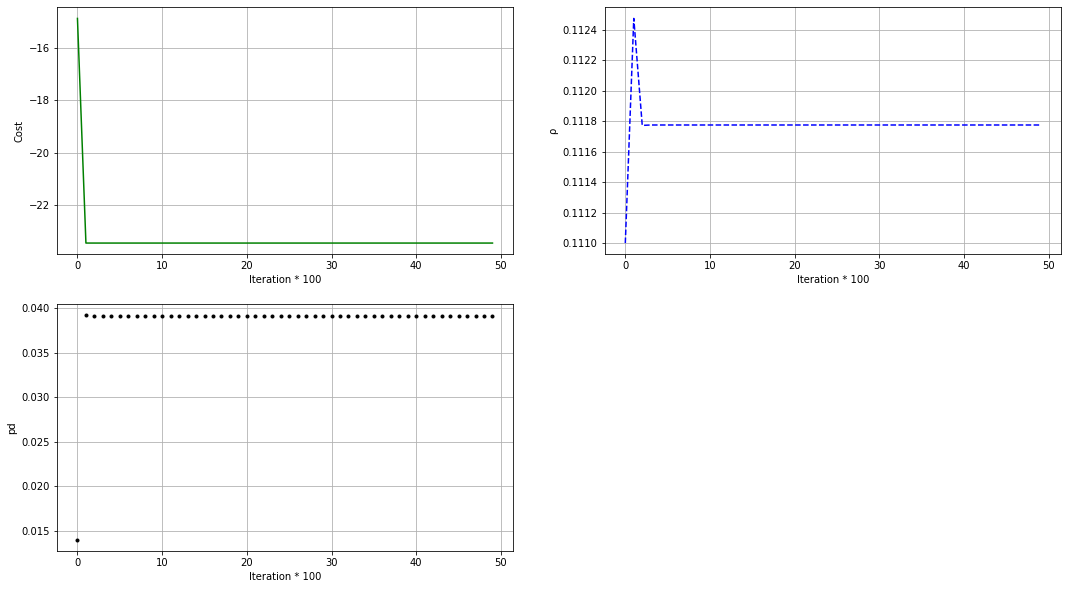

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))
ax[0, 0].plot(x, y[0], 'g')
ax[0, 0].set_ylabel("Cost")
ax[0, 0].set_xlabel('Iteration * %u' % step)
ax[0, 0].grid()
ax[0, 1].plot(x, y[1], 'b--')
ax[0, 1].set_ylabel("\u03C1")
ax[0, 1].set_xlabel('Iteration * %u' % step)
ax[0, 1].grid()
ax[1, 0].plot(x, y[2], 'k.')
ax[1, 0].set_ylabel("pd")
ax[1, 0].set_xlabel('Iteration * %u' % step)
ax[1, 0].grid()
fig.delaxes(ax[1, 1])

In [20]:
print("Cost after running optimizer for %d iterations: %.7f" % (num_iter, probability_ln()))
print("New values: \u03C1 = %.7f, pd = %.7f%%" % (ρ, pbd*100))

Cost after running optimizer for 5000 iterations: -23.4408813
New values: ρ = 0.1117741, pd = 3.9157100%


In [21]:
def dr_pdf(ρ, pd, drs):
    ''' Calculates the probability density function for annual default rates
    :param ρ: the copula correlation to use, it must be a scalar
    :param pd: the probability of default to use, it must be a scalar
    :param drs: the annual default rates, it must be a numpy array of floating point numbers in the range (0, 1)
    '''
    return  np.sqrt((1 - ρ)/ρ) * np.exp(.5 * (
                             np.square(norm.ppf(drs)) -
                             np.square((np.sqrt(1 - ρ)*norm.ppf(drs) - norm.ppf(pd))/np.sqrt(ρ))
                               ))
                            

Text(0.5, 0, 'Default rate')

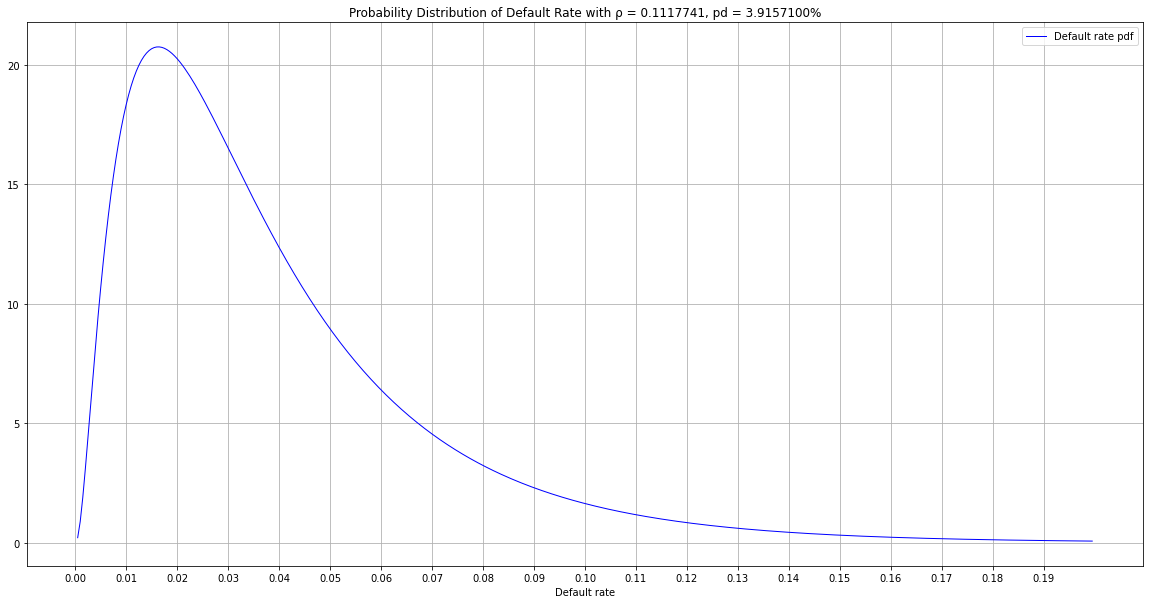

In [22]:
x = np.arange(5e-4, .2, 5e-4)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, dr_pdf(ρ, pbd, x), label="Default rate pdf", linewidth=1, color='b')
ax.legend(loc='best')
ax.grid(True)
ax.set_xticks(np.arange(0, .2, .01))
ax.set_title('Probability Distribution of Default Rate with \u03C1 = %.7f, pd = %.7f%%' % (ρ, pbd*100))
ax.set_xlabel('Default rate')

#### Exercise 11.17

In [23]:
# V1 is exponential with λ=1 and V2 is exponential with λ=2
# Gaussian copula correlation between V1 and V2 is -0.2
u1u2_bivar = multivariate_normal(cov=[[1, -.2],[-.2, 1]])
quantiles = np.arange(.25, 1.75, .25)

lamda1 = 1.
lamda2 = 2.
scale1 = 1. / lamda1
scale2 = 1. / lamda2

In [24]:
# Maps 'x' percentile to percentile from exponential with λ=1 and λ=2 to the standard normal distribution
from_exp_to_normal = lambda x, scale: norm.ppf(expon.cdf(x, scale=scale))

In [25]:
# Let's map exponentially distributed values to those distributed using the standard normal distribution
mapped_quantiles_1 = list(map(partial(from_exp_to_normal, scale=scale1), quantiles))
mapped_quantiles_2 = list(map(partial(from_exp_to_normal, scale=scale2), quantiles))

In [26]:
# Constucting a cumulative distribution table as a numpy matrix
l = len(quantiles)
cum_matrix = np.empty((l, l), dtype=np.float64)
for i in range(l):
    for j in range(l):
        cum_matrix[i, j] = u1u2_bivar.cdf([mapped_quantiles_1[i], mapped_quantiles_2[j]])

In [27]:
# Converting to a dataframe for ease of display
cum_matrix_df = pd.DataFrame(cum_matrix, index=pd.Index(quantiles, name='V1'),
                             columns=pd.Index(quantiles, name='V2'))
cum_matrix_df

V2,0.25,0.50,0.75,1.00,1.25,1.50
V1,,,,,,
0.25,0.064615,0.116790,0.153033,0.177242,0.193090,0.203335
0.50,0.125280,0.219296,0.282169,0.323005,0.349137,0.365705
0.75,0.176741,0.303424,0.386206,0.439076,0.472452,0.493371
1.00,0.219296,0.371354,0.469114,0.530822,0.569415,0.593413
1.25,0.254035,0.425759,0.534827,0.603079,0.645471,0.671682
1.50,0.282169,0.469114,0.586740,0.659861,0.705042,0.732856


#### Exercise 11.18

In [28]:
degr_freedom = 4
sample_size = 5000
ρ = .5
x = multivariate_t.rvs(shape=[[1, ρ],[ρ, 1]], df=degr_freedom, size=sample_size)

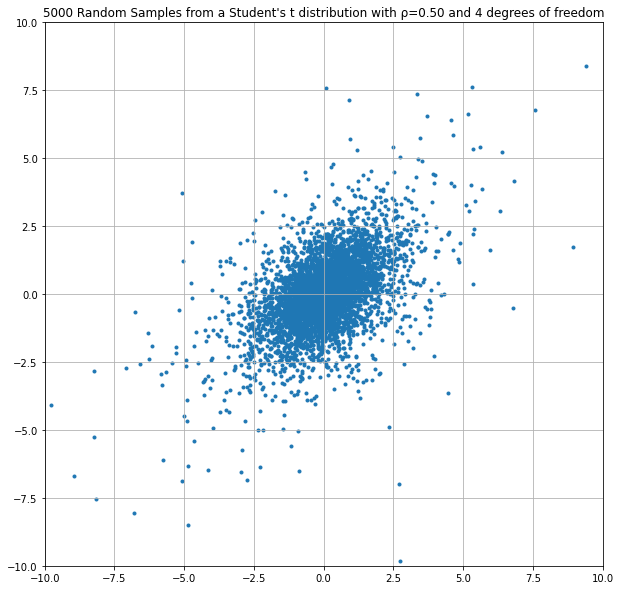

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x[:,0], x[:,1], marker='.')
ax.grid(True)
ax.set_title('{:d} Random Samples from a Student\'s t distribution with ρ={:.2f} '
             'and {:d} degrees of freedom'.format(sample_size, ρ, degr_freedom))
plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)

Now doing the same but starting with a bivariate normal with the same correlation structure and mapping it back to the marginal Student's t.

In [30]:
u = multivariate_normal.rvs(cov=[[1, ρ],[ρ, 1]], size=sample_size)
u_unif = norm.cdf(u)
v = t.ppf(u_unif, df=degr_freedom)

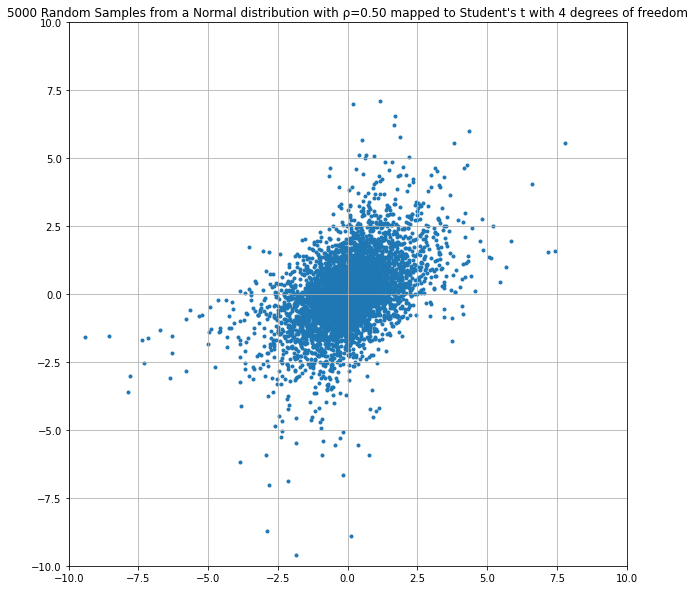

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(v[:,0], v[:,1], marker='.')
ax.grid(True)
ax.set_title('{:d} Random Samples from a Normal distribution with ρ={:.2f} '
             'mapped to Student\'s t with {:d} degrees of freedom'.format(sample_size, ρ, degr_freedom))
plt.xlim(-10, 10)
_ = plt.ylim(-10, 10)

#### Exercise 11.19

In [32]:
def wcdr(ρ, x, pd):    
    ''' Calculates the the worst case default rate (WCDR) at a given confidence level for
    a large portfolio of loans each of which has the same probability of default within a given time horizon.
    This formula constitutes Vasicek's model.
    :param ρ: the copula correlation to use, it can be a scalar in range [0, 1) or a vector
    :param x: the confidence level for calculating the worst case default rate,
              it can be scalar in range [0, 1] or a vector
    :param pd: the probability of default of an individual loan, it can be a scalar or a vector
    '''
    if type(ρ) is not np.ndarray:
        ρ = np.array(ρ)
    assert np.all((0 <= ρ) & (ρ < 1)), 'Copula correlation must be in range [0, 1)'
    return norm.cdf((norm.ppf(pd) + np.sqrt(ρ) * norm.ppf(x)) / np.sqrt(1. - ρ))

In [33]:
pbd = .012
conf_level = .9997
rho = [i / 100. for i in range(0, 100)]
wcdrs = wcdr(rho, conf_level, pbd)

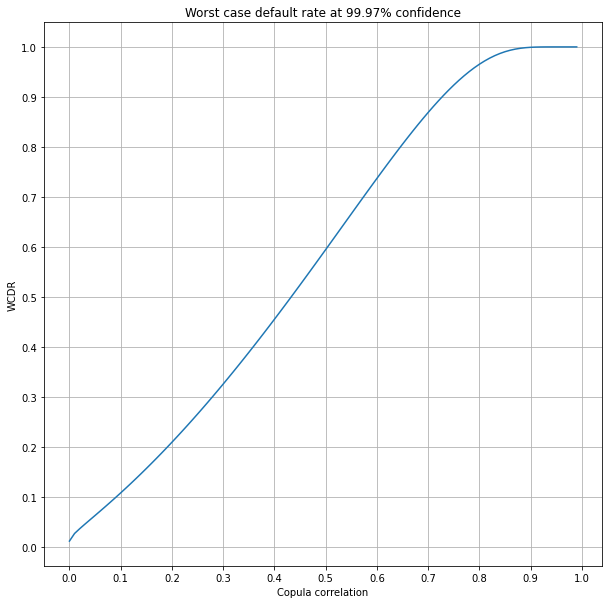

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(rho, wcdrs)
ax.grid(True)
ax.set_xticks(np.arange(0, 1.01, .1))
ax.set_yticks(np.arange(0, 1.01, .1))
ax.set_title('Worst case default rate at {:.2%} confidence'.format(conf_level))
ax.set_xlabel('Copula correlation')
_ = ax.set_ylabel('WCDR')

#### Exercise 11.20
This exercise is pretty similar to 11.15. For a change I will use SciPy's optimization module instead of 
TensorFlow in order to solve it. It actually turns out to be easier to use.

In [35]:
# The default rates in the past 15 years of a large portfolio of loans
drs = [.02, .04, .07, .12, .06, .05, .08, .14, .1, .02, .03, .02, .06, .07, .09]
conf_level = .999

Reusing the `dr_pdf` function defined above for Exercise 11.15.

In [36]:
def log_of_dr_pdf(ρ, pd, dr):
    ''' Calculates the natural logarithm of the probability density function of default rate of
    a large portfolio of loans each of which has the same probability of default within a given time horizon.
    :param ρ: the copula correlation to use, it must be a scalar in range [0, 1)
    :param pd: the probability of default of an individual loan, it must be a scalar
    :param dr: an observation of an actual default rate of the porfolio
    '''
    return np.log(dr_pdf(ρ, pd, dr))

In [37]:
def objective_func(x):
    """ Searches for optimal values of the ρ, and PD parameters of Vasicek's model. """
    ρ, pd = x

    sum = 0.
    for dr in drs:
        # Inverting the sign since SciPy's optimization module has methods for minimizing objective functions only
        sum -= log_of_dr_pdf(ρ, pd, dr)

    return sum

In [38]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

# Initial values for ρ and pd parameters for Vasicek's model
x0 = np.array([.01, .05], dtype=np.float64)

# ρ[0, 1), pd[0, 1]
bounds = Bounds([0., 0.], [np.nextafter(1, 0), 1.])

res = minimize(objective_func, x0, method='Nelder-Mead', bounds=bounds)

if res.success:
    ρ, pbd = res.x
    print('Objective function: %.5f after %d iterations\n' % (-res.fun, res.nit))
else:
    raise ValueError("Optimizing the objective function with the passed default rates didn't succeed")

print('Maximume likelihood values: ρ={:.5f}, PD={:.5f}'.format(ρ, pbd))
print('WCDR at {:.2%} confidence level: {:.5f}'.format(conf_level, wcdr(ρ, conf_level, pbd)))

Objective function: 29.78880 after 35 iterations

Maximume likelihood values: ρ=0.08592, PD=0.06479
WCDR at 99.90% confidence level: 0.26174


In [39]:
# Probability distribution of the default rate
conf_levels = [i / 100. for i in range(0, 100)]
wcdrs = wcdr(ρ, conf_levels, pbd)

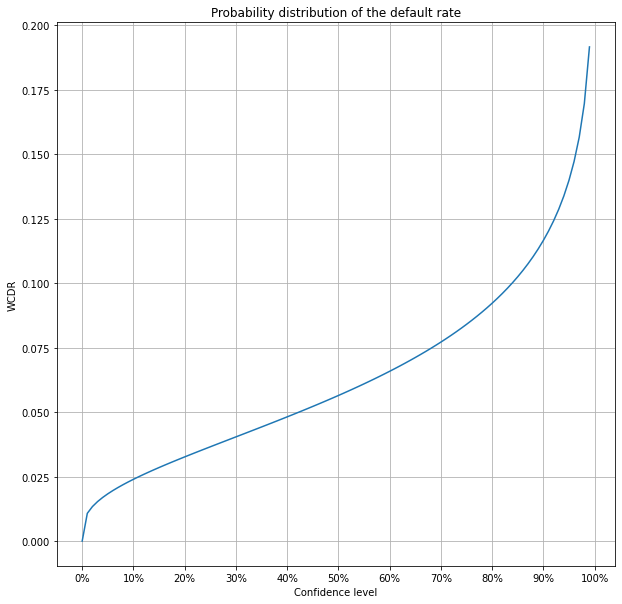

In [40]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(conf_levels, wcdrs)
ax.grid(True)
ax.set_xticks(np.arange(0, 1.01, .1))
ax.set_title('Probability distribution of the default rate')
ax.set_xlabel('Confidence level')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_ylabel('WCDR')